In [149]:
suppressMessages(library(Seurat))
suppressMessages(library(SeuratWrappers))
suppressMessages(library(monocle3))
suppressMessages(library(tidyverse))
library(parallel)
library(patchwork)
library(xlsx)
library(ggsci)

In [192]:
seuratobj=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [193]:
metadata_excel=read.xlsx('/mnt/MXMERZ002A/LargeData/metadata.xlsx', sheetName='Sheet2')
metadata_excel=metadata_excel %>% select(barcode, collection.day) 

In [ ]:
seuratobj@meta.data=seuratobj@meta.data %>% select(!collection.day) %>% rownames_to_column('cellrownames') %>%
left_join(metadata_excel %>% mutate(collection.day=as.character(collection.day))) %>%
column_to_rownames('cellrownames')

In [195]:
seuratobj$ciltacabtagene_pos=ifelse(GetAssayData(seuratobj, slot='counts', assay = 'RNA')['ciltacabtagene',]>0, 
                                 'CAR+',
                                 'CAR-')

In [197]:
seuratobj@meta.data=seuratobj@meta.data %>% mutate(timepoint=ifelse(days.since.apharesis<2, 'pre','post'))

In [95]:
seuratobj_cilta=seuratobj[, seuratobj$patient %in% c(7, 8)&
                          seuratobj$WNN_agg %in% c('CD8 T cells', 'CD4 T cells')]

In [96]:
seuratobj_cilta=seuratobj_cilta[,!(seuratobj_cilta$timepoint=='pre'&
seuratobj_cilta$ciltacabtagene_pos=='CAR+')]

In [98]:
seuratobj_cilta@meta.data=seuratobj_cilta@meta.data %>% 
unite(collection.day_CAR, collection.day, ciltacabtagene_pos, remove = F) %>%
unite(patient_WNNagg_collection.day_CAR, patient, WNN_agg, collection.day_CAR, remove = F)

In [100]:
Idents(seuratobj_cilta)='patient_WNNagg_collection.day_CAR'
seuratobj_cilta_ds=subset(seuratobj_cilta, downsample=1000)

In [101]:
table(seuratobj_cilta$patient_WNNagg_collection.day_CAR)


7_CD4 T cells_2021-08-16_CAR- 7_CD4 T cells_2022-01-04_CAR- 
                          503                           244 
7_CD4 T cells_2022-01-04_CAR+ 7_CD8 T cells_2021-08-16_CAR- 
                           16                           858 
7_CD8 T cells_2022-01-04_CAR- 7_CD8 T cells_2022-01-04_CAR+ 
                           33                            12 
8_CD4 T cells_2021-09-03_CAR- 8_CD4 T cells_2021-12-21_CAR- 
                          264                          3429 
8_CD4 T cells_2021-12-21_CAR+ 8_CD8 T cells_2021-09-03_CAR- 
                           60                           881 
8_CD8 T cells_2021-12-21_CAR- 8_CD8 T cells_2021-12-21_CAR+ 
                         3540                            54 

In [118]:
table(seuratobj_cilta_ds$patient_WNNagg_collection.day_CAR)


7_CD4 T cells_2021-08-16_CAR- 7_CD4 T cells_2022-01-04_CAR- 
                          503                           244 
7_CD4 T cells_2022-01-04_CAR+ 7_CD8 T cells_2021-08-16_CAR- 
                           16                           858 
7_CD8 T cells_2022-01-04_CAR- 7_CD8 T cells_2022-01-04_CAR+ 
                           33                            12 
8_CD4 T cells_2021-09-03_CAR- 8_CD4 T cells_2021-12-21_CAR- 
                          264                          1000 
8_CD4 T cells_2021-12-21_CAR+ 8_CD8 T cells_2021-09-03_CAR- 
                           60                           881 
8_CD8 T cells_2021-12-21_CAR- 8_CD8 T cells_2021-12-21_CAR+ 
                         1000                            54 

In [202]:
seuratobj_old=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.bak')

In [ ]:
seuratobj_old@meta.data=seuratobj_old@meta.data %>% select(!collection.day) %>% rownames_to_column('cellrownames') %>%
left_join(metadata_excel %>% mutate(collection.day=as.character(collection.day))) %>%
column_to_rownames('cellrownames')

In [227]:
seuratobj_old$idecabtagene_pos=ifelse(GetAssayData(seuratobj_old, slot='counts', assay = 'RNA')['idecabtagene',]>0, 
                                 'CAR+',
                                 'CAR-')

In [230]:
seuratobj_old@meta.data=seuratobj_old@meta.data %>% mutate(timepoint=ifelse(days.since.apharesis<2, 'pre','post'))

In [231]:
seuratobj_ide=seuratobj_old[, seuratobj_old$patient %in% c(12, 14)&
                            seuratobj_old$WNN_agg %in% c('CD8 T cells', 'CD4 T cells')]

In [232]:
seuratobj_ide=seuratobj_ide[,!(seuratobj_ide$timepoint=='pre'&
seuratobj_ide$idecabtagene_pos=='CAR+')]

In [233]:
seuratobj_ide@meta.data=seuratobj_ide@meta.data %>% 
unite(collection.day_CAR, collection.day, idecabtagene_pos, remove = F) %>%
unite(patient_WNNagg_collection.day_CAR, patient, WNN_agg, collection.day_CAR, remove = F)

In [8]:
get_earliest_principal_node <- function(cds, timepoint="pre"){
  cell_ids <- which(colData(cds)[, "timepoint"] == timepoint)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

In [172]:
plot_trajectories=function(seuratobj, patientid, celltype, cellsource, cells=NULL, pickroot=NULL, color_cells_by='collection.day'){

if (is.null(cells)) {
    cellstoplot=seuratobj@meta.data %>% 
    filter(patient==patientid) %>% 
    filter(WNN_agg==celltype)%>%
    filter(source %in% cellsource) %>%
    rownames
    seurat_toplot=seuratobj[, cellstoplot]
}    else {
        seurat_toplot=seuratobj[, cells]}

cds<- as.cell_data_set(seurat_toplot)
cds <- preprocess_cds(cds, method='PCA', num_dim = 50)
cds <- estimate_size_factors(cds) 
cds <- reduce_dimension(cds, preprocess_method='PCA', cores=1)
cds <- cluster_cells(cds)
cds <- learn_graph(cds, use_partition = F)

p1=plot_cells(cds,
           color_cells_by = color_cells_by,
              #cell_size=0.5,
           label_groups_by_cluster=T,
           label_leaves=FALSE,
           label_branch_points=FALSE,
          label_cell_groups=F)+ggtitle('Trajectory by date')+
    scale_color_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=10)[c(2,5,9)])
    
if (is.null(pickroot)){
    cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))
   
}
    else{
         cds <- order_cells(cds, root_pr_nodes=pickroot)
        }

p2=plot_cells(cds,
       color_cells_by = "pseudotime",
       label_groups_by_cluster=T,
       label_leaves=FALSE,
       label_branch_points=FALSE,
      label_cell_groups=F)

cds_degs <- graph_test(cds, neighbor_graph="principal_graph", cores=detectCores())
rowData(cds)$gene_short_name=rownames(cds)

pseudotime_genes_toplot=cds_degs %>% filter(q_value<0.05) %>% 
rownames_to_column('genes') %>%
arrange(q_value, -morans_test_statistic) %>% 
filter( !grepl('^RP[LS]', genes),!grepl('^IG[KLH]V', genes)) %>% 
slice_head(n=6) %>% select(genes) %>% unlist

p3=plot_cells(cds, genes=pseudotime_genes_toplot,
       show_trajectory_graph=FALSE,
       label_cell_groups=FALSE,
           label_leaves=FALSE)+theme(strip.text.x = element_text(size = 14))
    
return(list(p1, p2, p3, cds_degs, cds))}

In [105]:
replot_root=function(p, pickroot){
cds=p[[5]]
cds <- order_cells(cds, root_pr_nodes=pickroot)
    
p[[2]]=plot_cells(cds,
       color_cells_by = "pseudotime",
       label_groups_by_cluster=T,
       label_leaves=FALSE,
       label_branch_points=FALSE,
      label_cell_groups=F)
    
   
return(p)
}

In [36]:
plot_all=function(p){

    (p[[1]]+p[[2]])/p[[3]]+ 
    plot_annotation(title = paste('Patient', patientid, celltype, paste0('(',paste0(cellsource, collapse = '+'),')')), 
                    theme = theme(plot.title = element_text(size = 18)),
                   tag_levels = 'A')
    }

In [ ]:
options(warn = -1)

# Pseudotime Trajectory with Monocle3 for Patient 7, 8, 12 and 14.

The node in the trajectory with the largest number of cells at the earliest time point in the vicinity is assigned pseudotime 0. Monocle 3's implementation of Moran's I test is used to identify genes that vary with trajectory. 

Subplot A: Trajectory annotated by date of sample acquisition

Subplot B: Trajectory annotated by pseudotime

Subplot C: Relative expression levels of top 6 genes ranked by Moran test statistic overlaid onto trajectory. Ribosomal genes are excluded. 

In [22]:
options(repr.plot.width = 14, repr.plot.height = 12)

CAR+ T cells for patients 7 and 8 are Ciltacabtagene, and for patients 12 and 14 are Idecabtagene. 
For patient 7, the 2 samples from pre and post CART treatment were from PBMC and BM respectively. To trace the trajectory between the 2 timepoints we thus have to include both cell sources. 

In [ ]:
patientid=7
celltype='CD4 T cells'
cellsource=c('PB','BM')
p7_CD4=plot_trajectories(seuratobj_cilta_ds, patientid, celltype, cellsource, color_cells_by='collection.day_CAR')
#plot_all(p7_CD4)

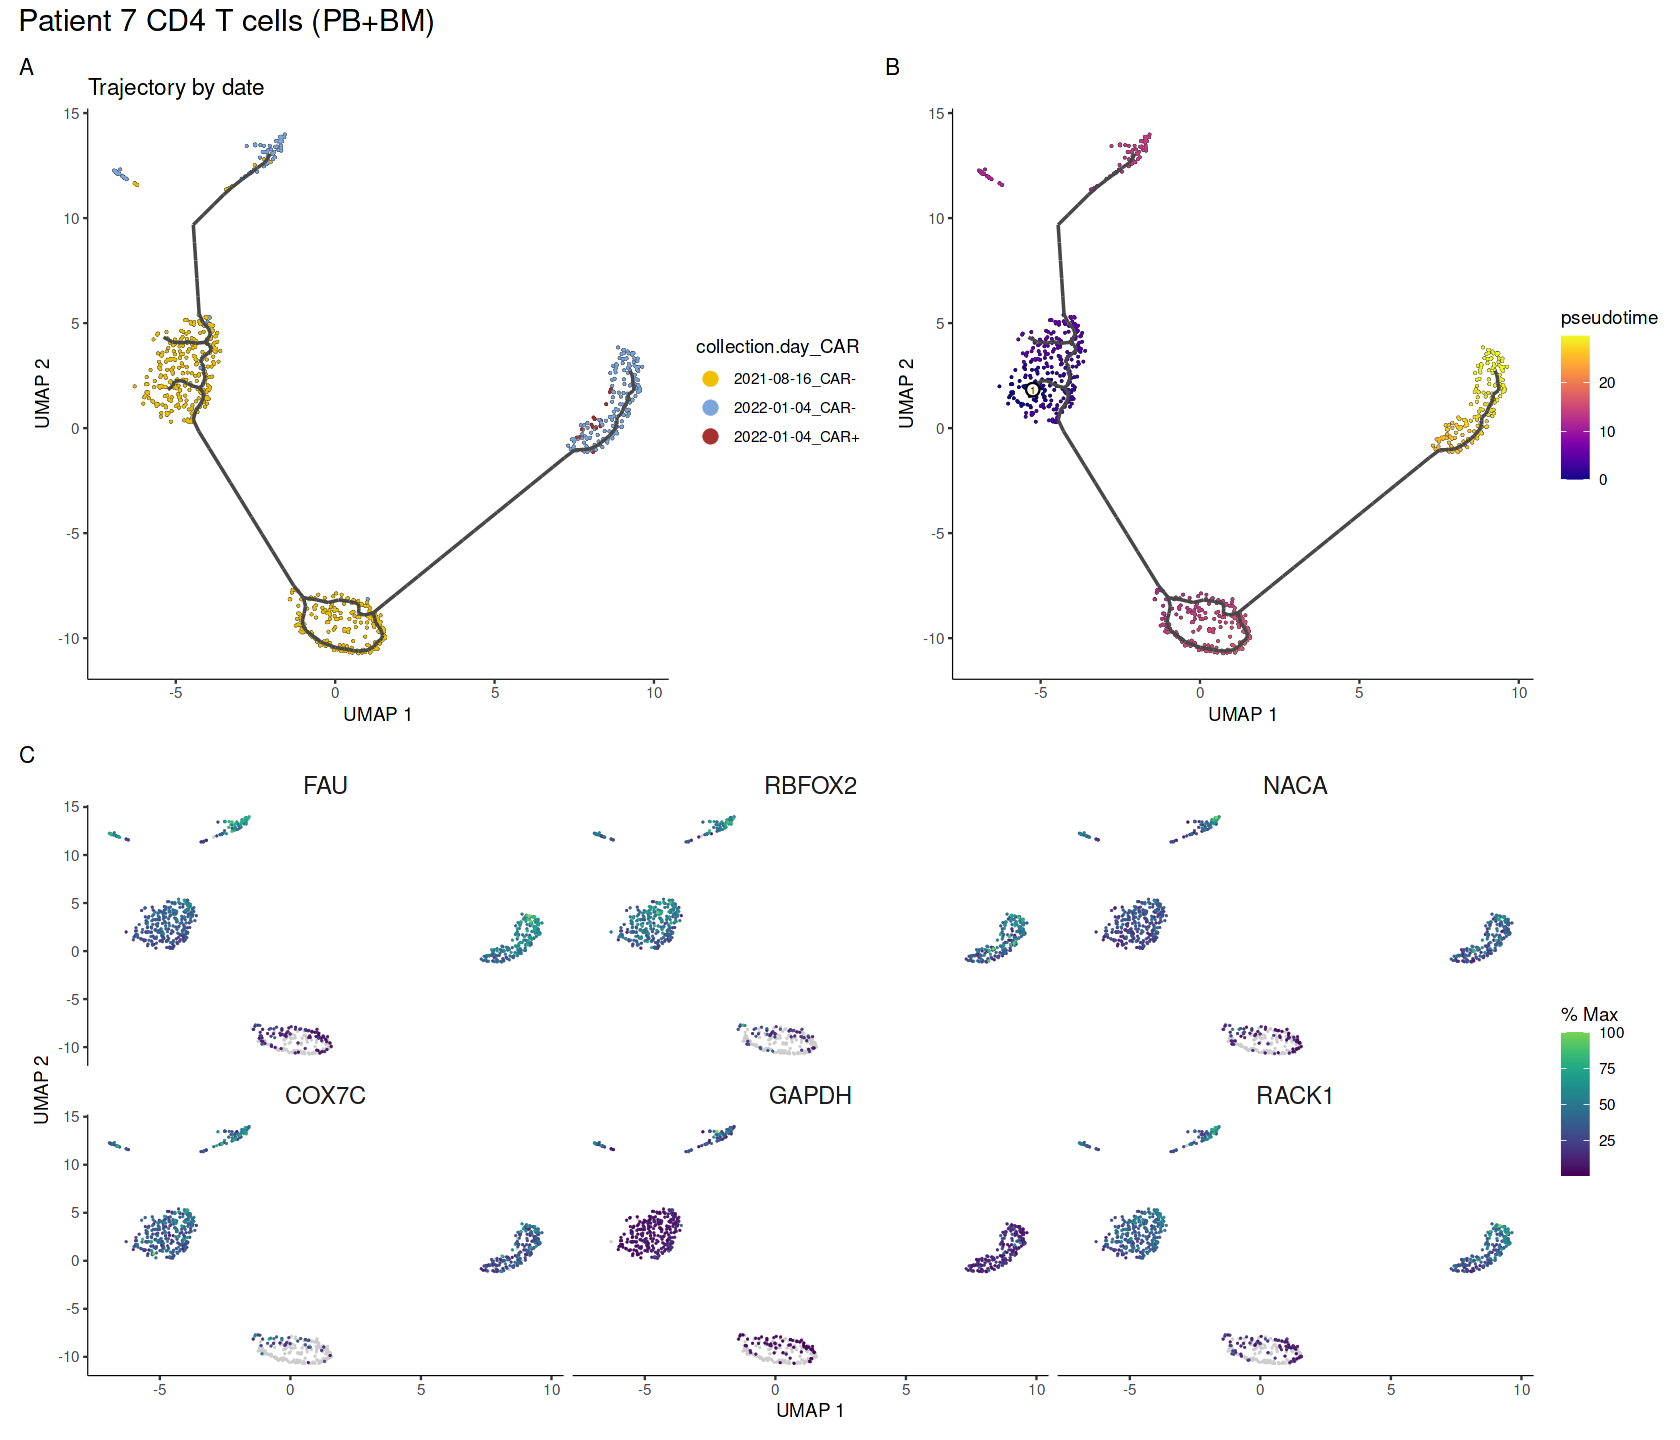

In [182]:
patientid=7
celltype='CD4 T cells'
cellsource=c('PB','BM')
plot_all(p7_CD4)

Fig 1

In [ ]:
patientid=7
celltype='CD8 T cells'
cellsource=c('PB','BM')
p7_CD8=plot_trajectories(seuratobj_cilta_ds, patientid, celltype, cellsource, color_cells_by='collection.day_CAR')
#plot_all(p7_CD8)

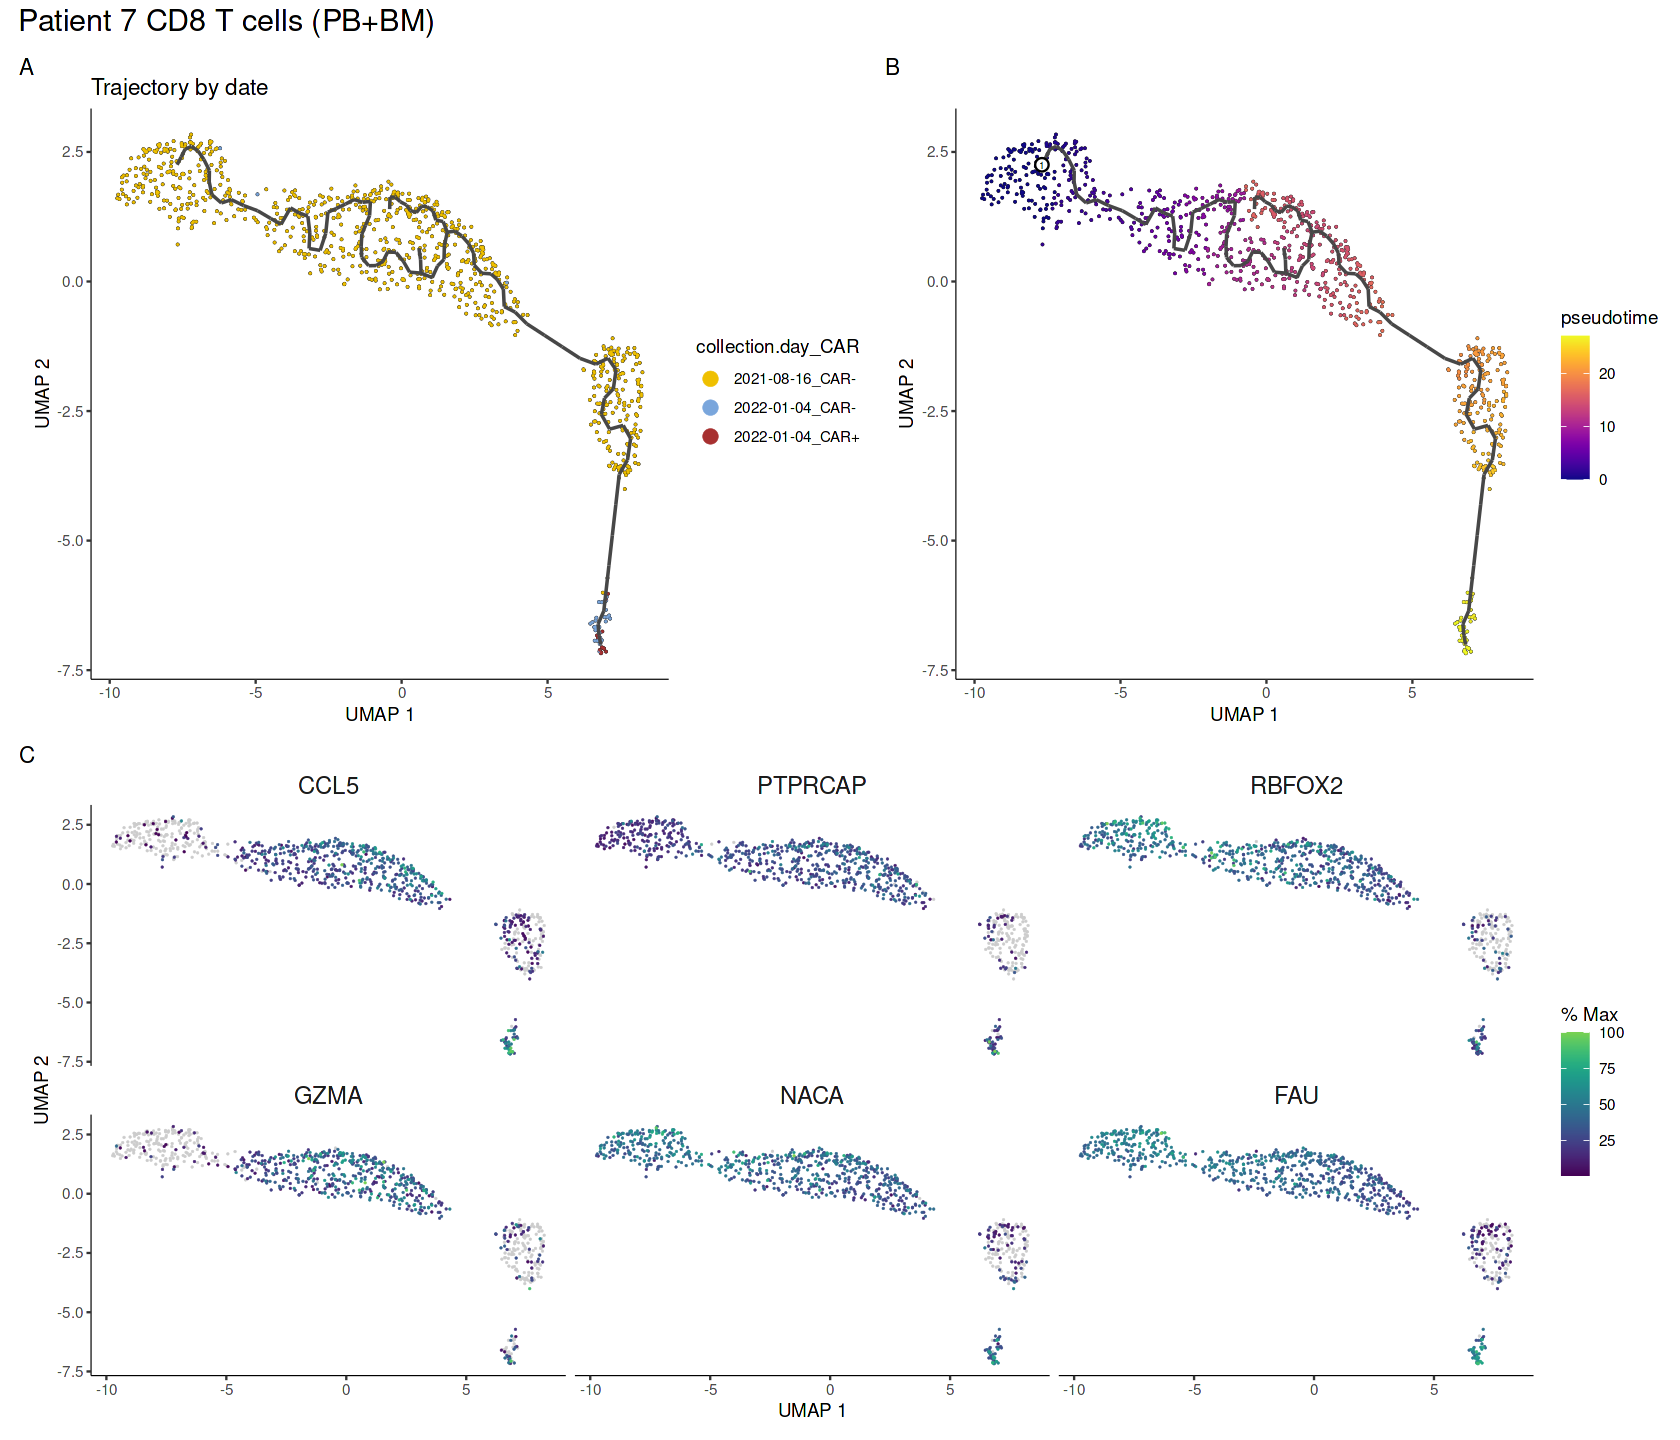

In [180]:
patientid=7
celltype='CD8 T cells'
cellsource=c('PB','BM')
plot_all(p7_CD8)

Fig 2

Patient 8 CD4 2021-12-21_CAR- T cells (blue) have been downsampled from 3429 to 1000 cells so as not to completely occlude the CAR+ cells (red) on the trajectory plot.

In [ ]:
patientid=8
celltype='CD4 T cells'
cellsource=c('PB')
p8_CD4=plot_trajectories(seuratobj_cilta_ds, patientid, celltype, cellsource, color_cells_by='collection.day_CAR')
#plot_all(p8_CD4)

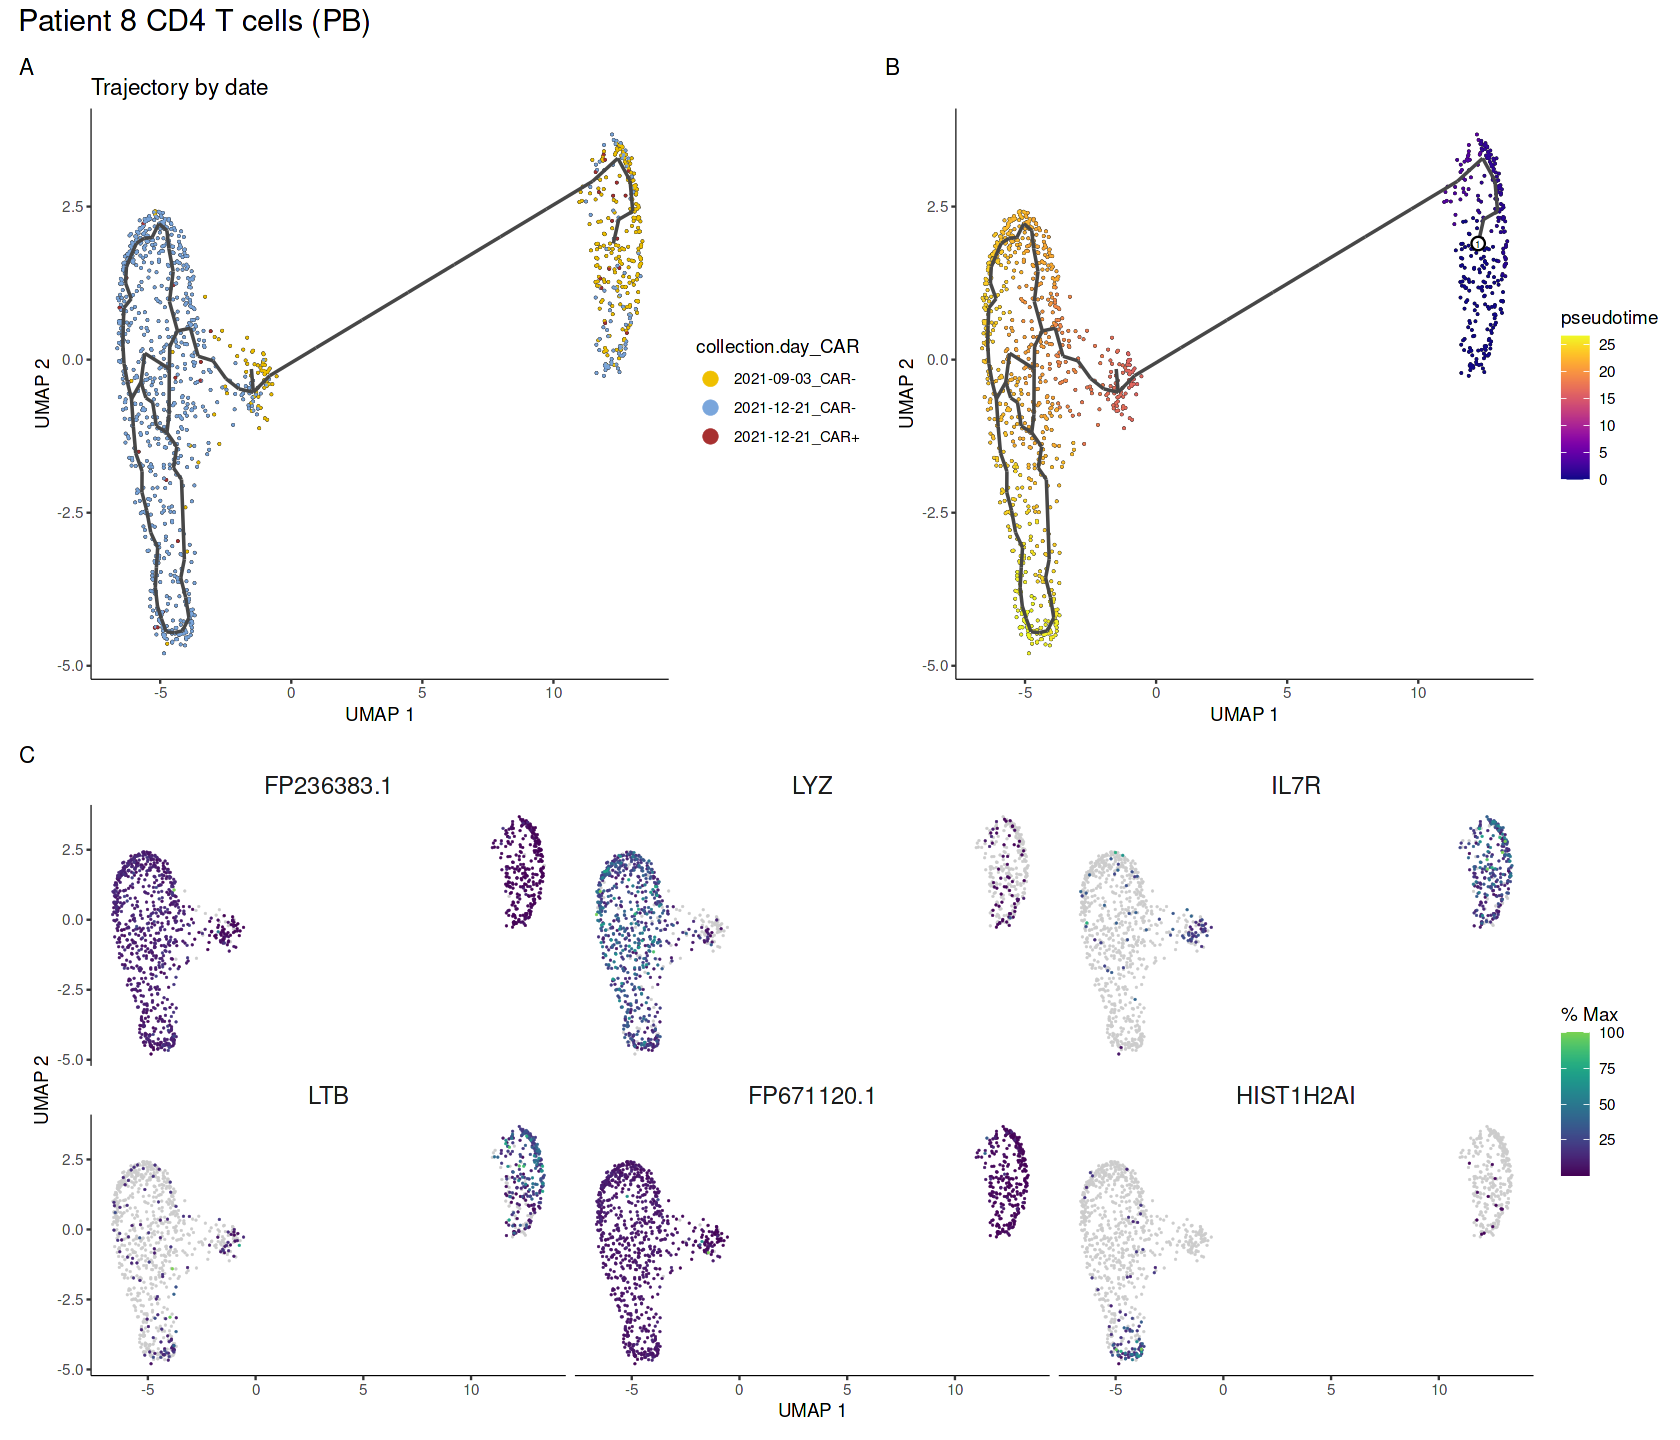

In [174]:
patientid=8
celltype='CD4 T cells'
cellsource=c('PB')
plot_all(p8_CD4)

Fig 3

Patient 8 CD8 2021-12-21_CAR- T cells (blue) have been downsampled from 3540 to 1000 cells so as not to completely occlude the CAR+ cells (red) on the trajectory plot.

In [ ]:
patientid=8
celltype='CD8 T cells'
cellsource=c('PB')
p8_CD8=plot_trajectories(seuratobj_cilta_ds, patientid, celltype, cellsource, color_cells_by='collection.day_CAR')
#plot_all(p8_CD8)

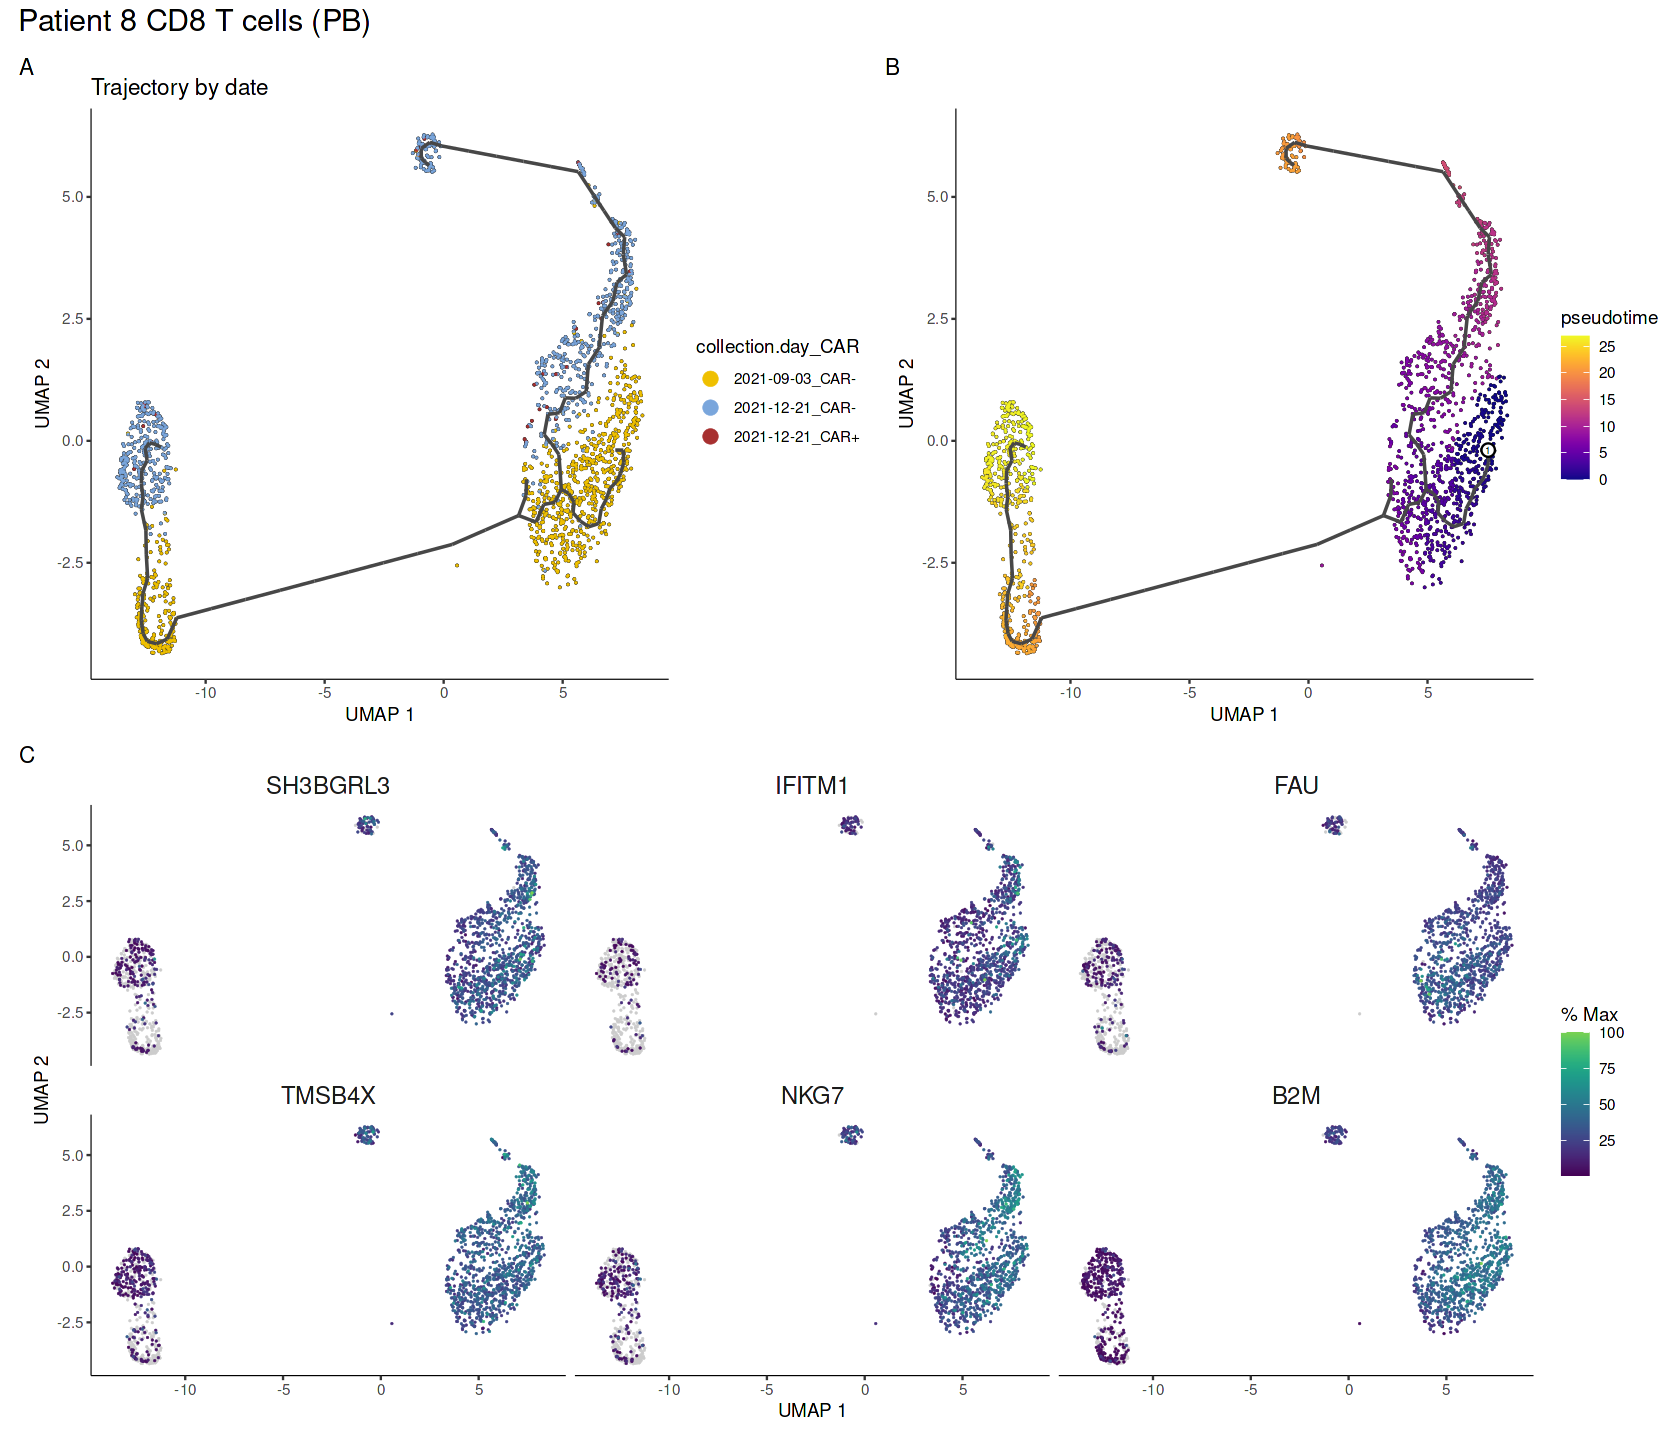

In [178]:
patientid=8
celltype='CD8 T cells'
cellsource=c('PB')
plot_all(p8_CD8)

Fig 4

In [ ]:
patientid=12
celltype='CD4 T cells'
cellsource='PB'
p12_CD4=plot_trajectories(seuratobj_ide, patientid, celltype, cellsource, color_cells_by='collection.day_CAR', pickroot='Y_118')
#plot_all(p12_CD4)


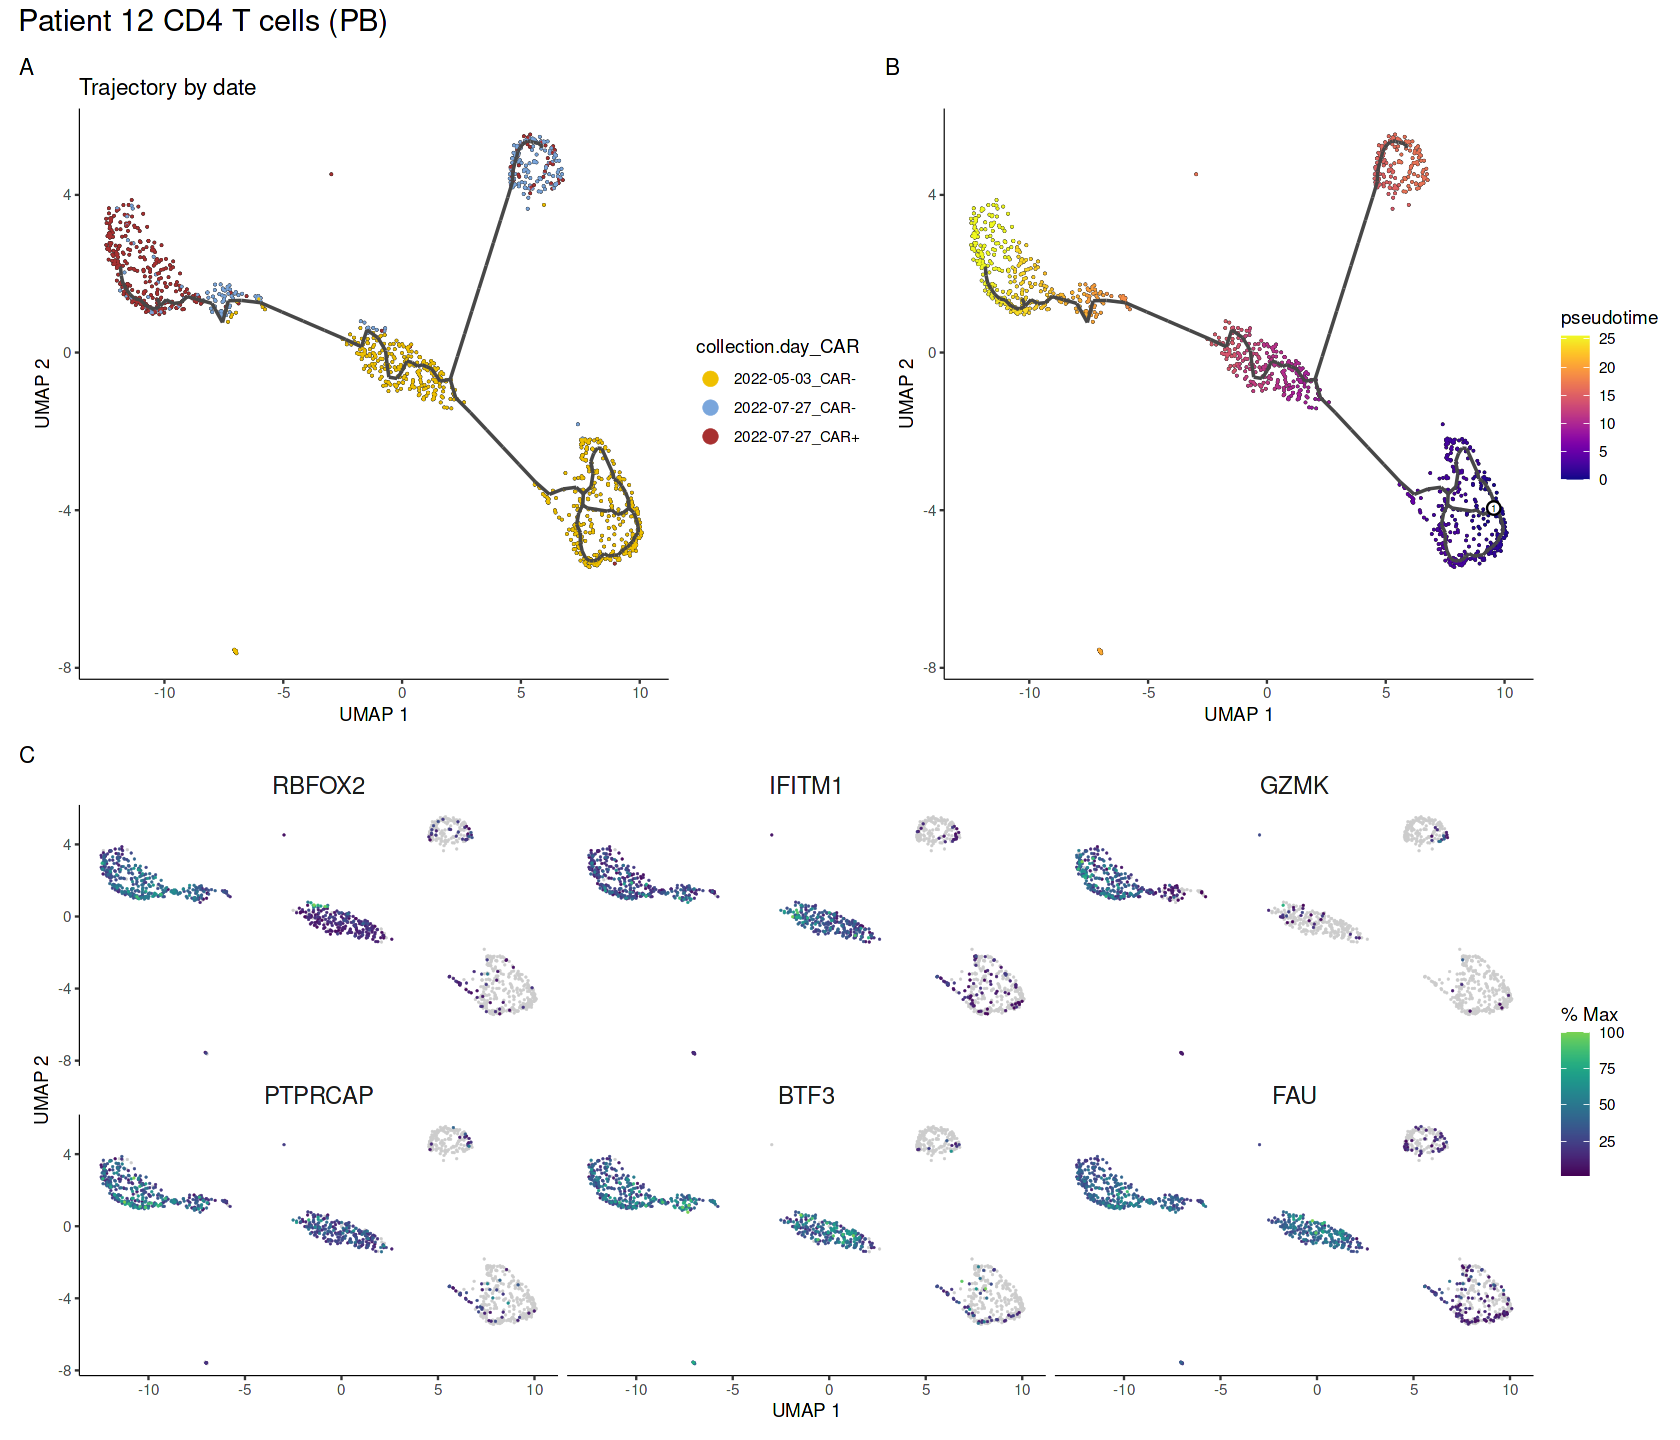

In [236]:
plot_all(p12_CD4)

Fig 5

In [ ]:
patientid=12
celltype='CD8 T cells'
cellsource='PB'
p12_CD8=plot_trajectories(seuratobj_ide, patientid, celltype, cellsource, color_cells_by='collection.day_CAR')

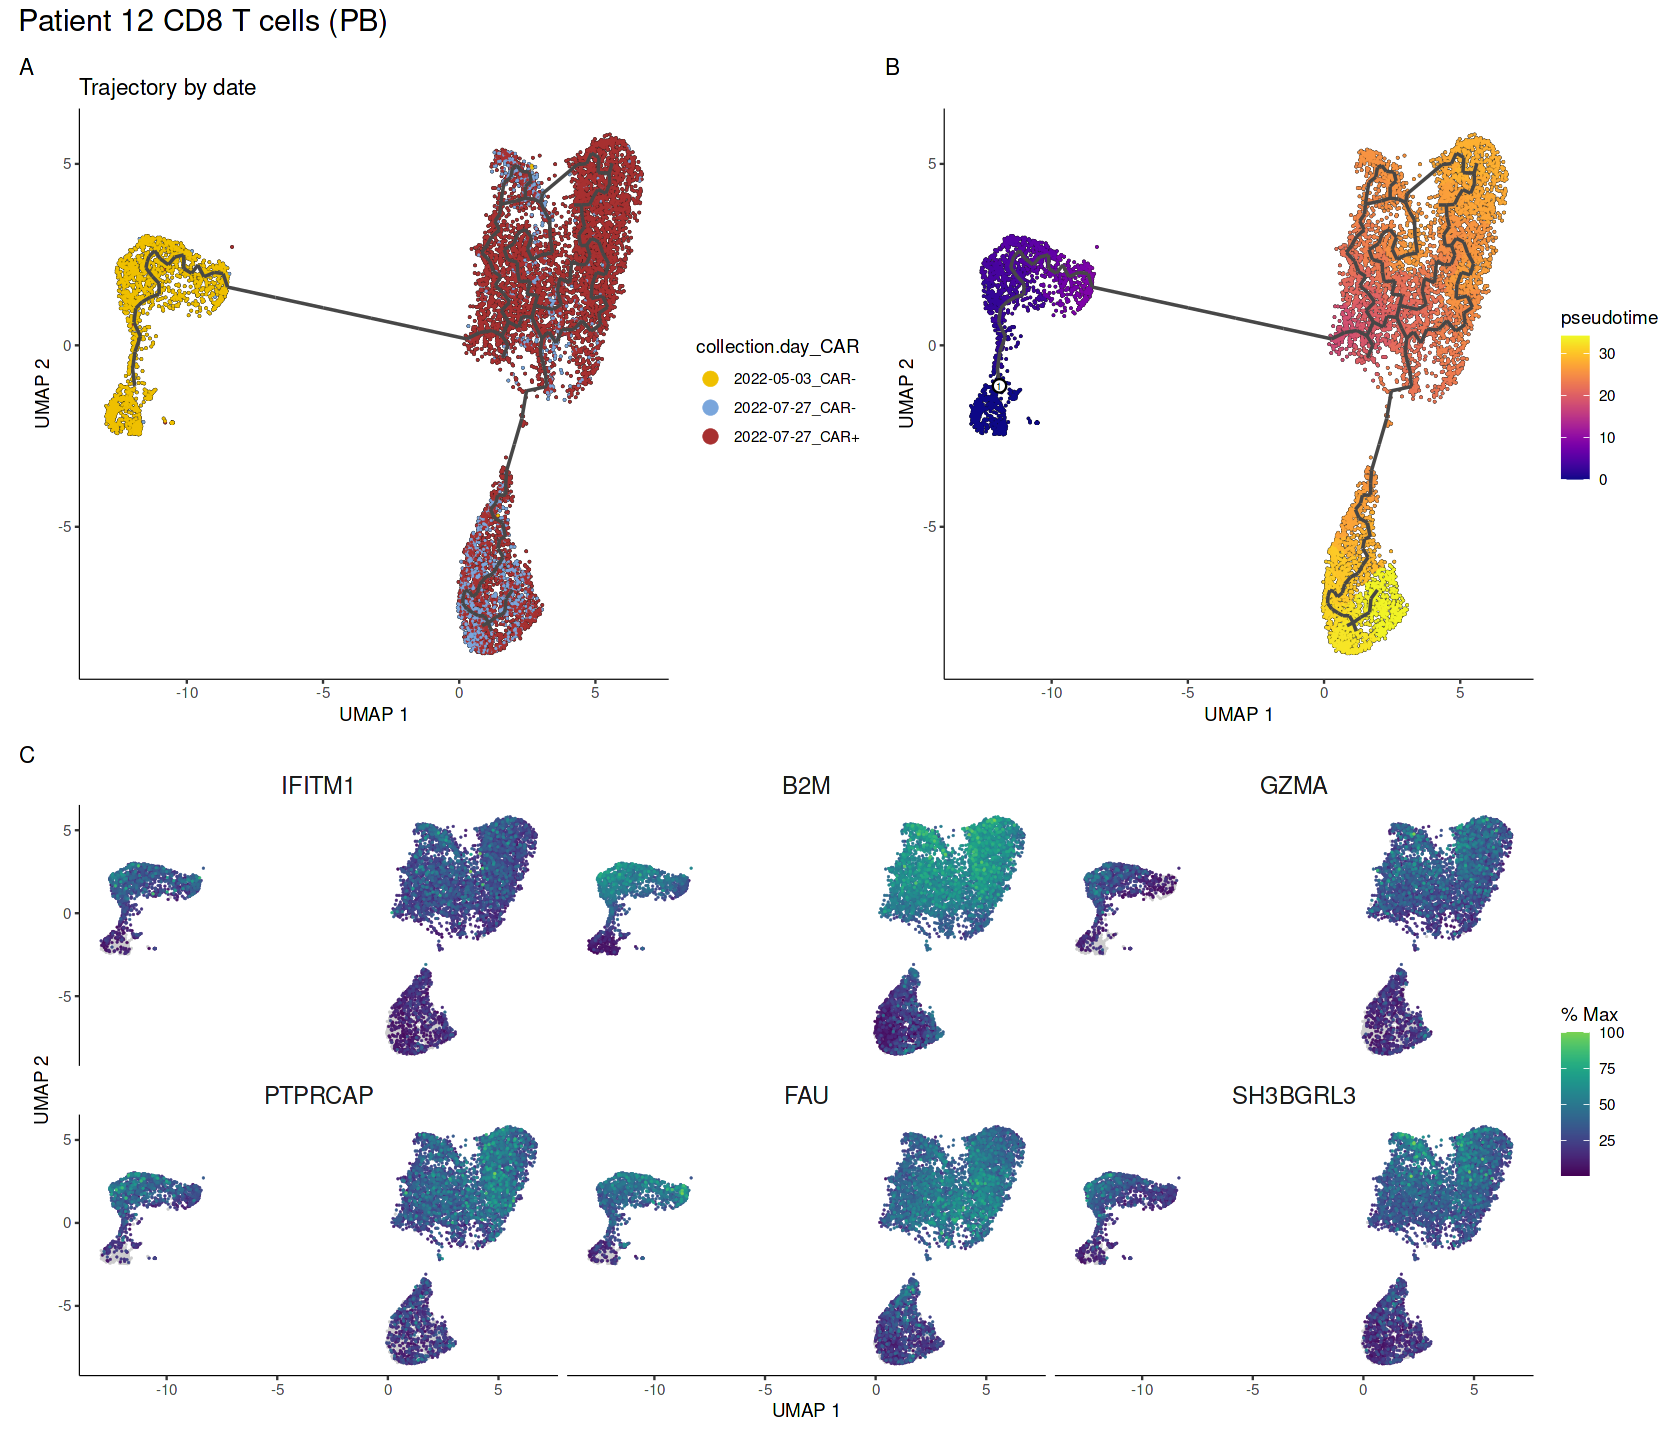

In [240]:
plot_all(p12_CD8)

Fig 6

In [ ]:
patientid=14
celltype='CD4 T cells'
cellsource='PB'
p14_CD4=plot_trajectories(seuratobj_ide, patientid, celltype, cellsource, color_cells_by='collection.day_CAR')

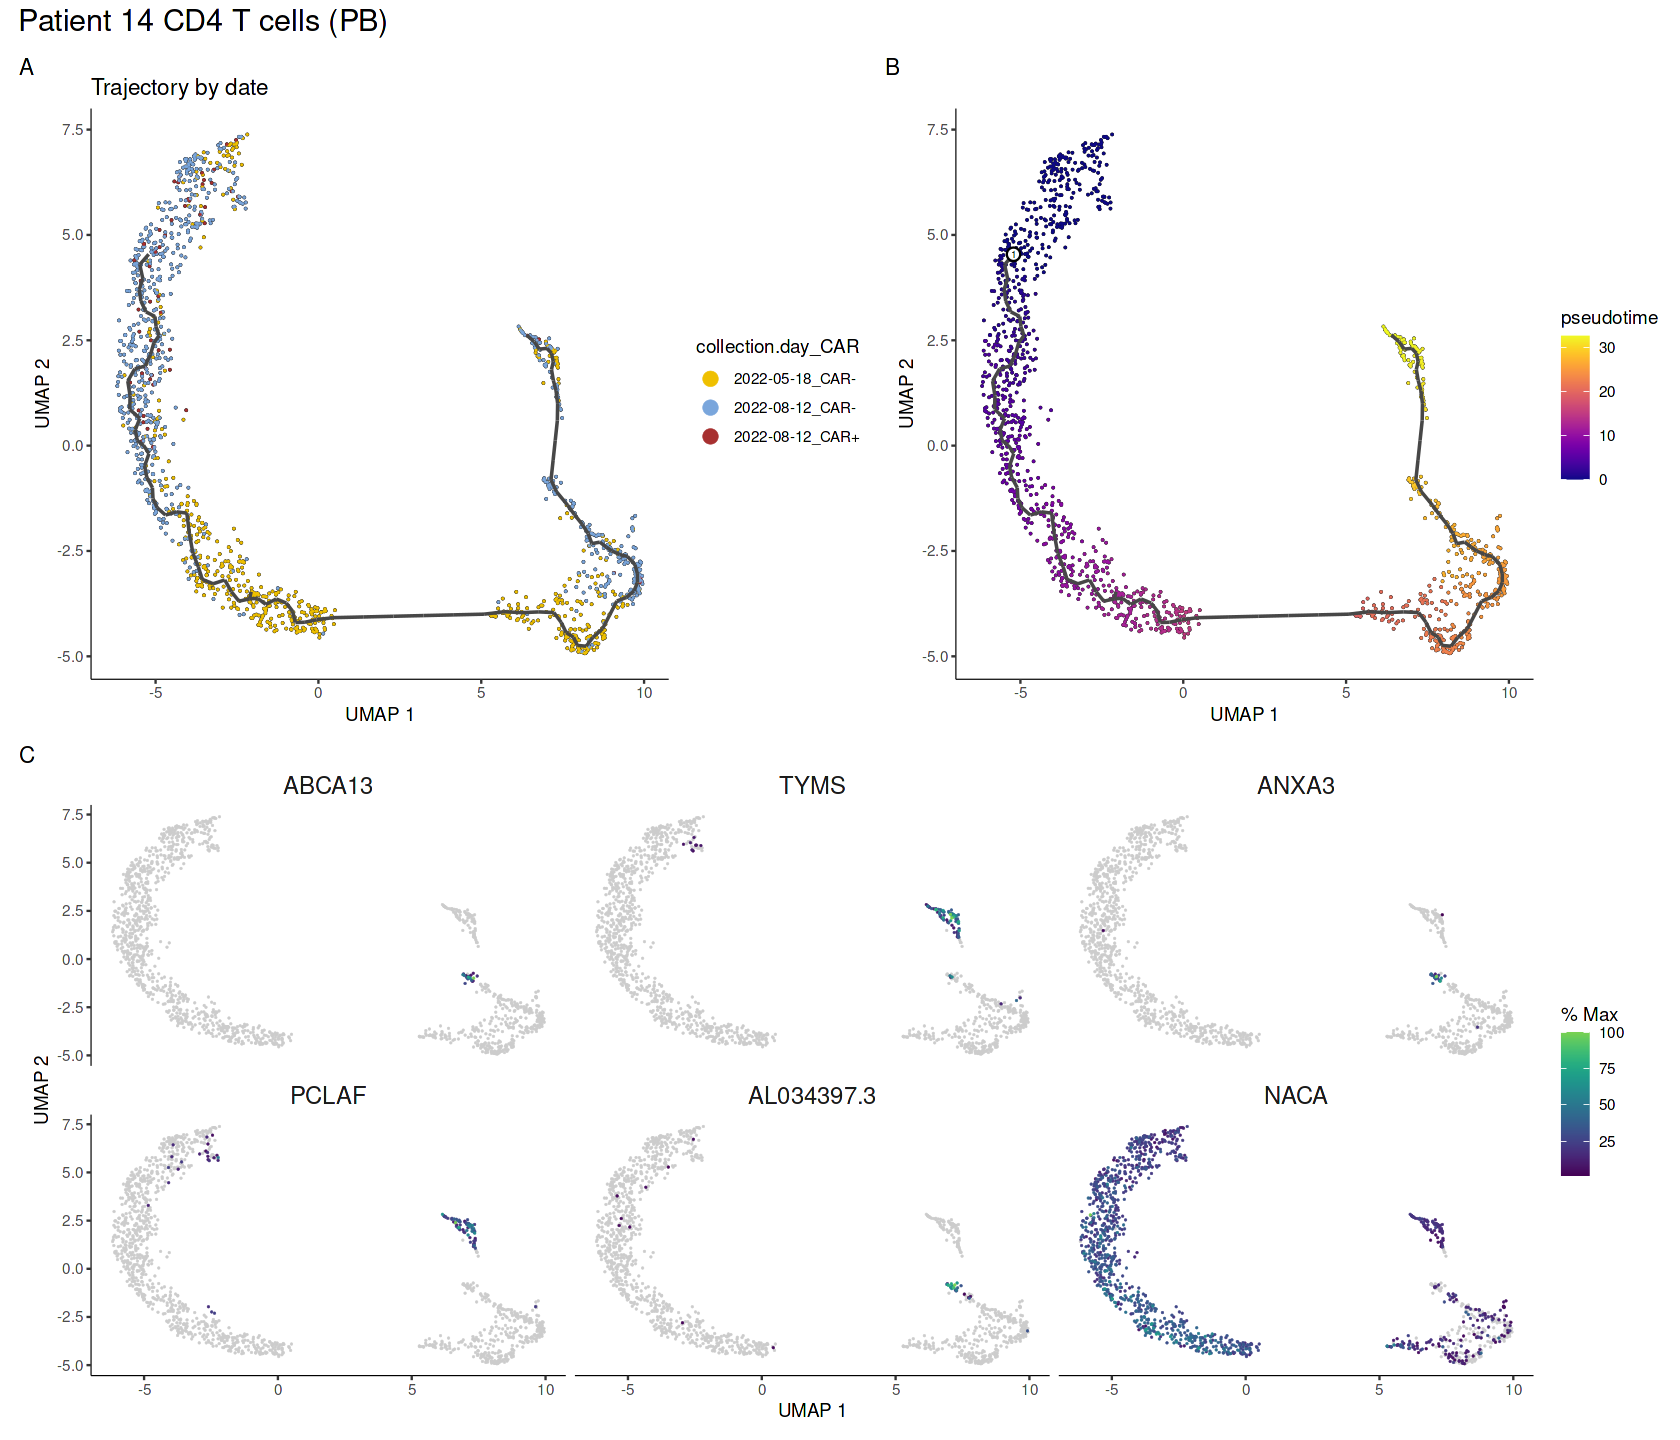

In [245]:
plot_all(p14_CD4)

Fig 7

In [ ]:
patientid=14
celltype='CD8 T cells'
cellsource='PB'
p14_CD8=plot_trajectories(seuratobj_ide, patientid, celltype, cellsource, color_cells_by='collection.day_CAR', pickroot='Y_63')

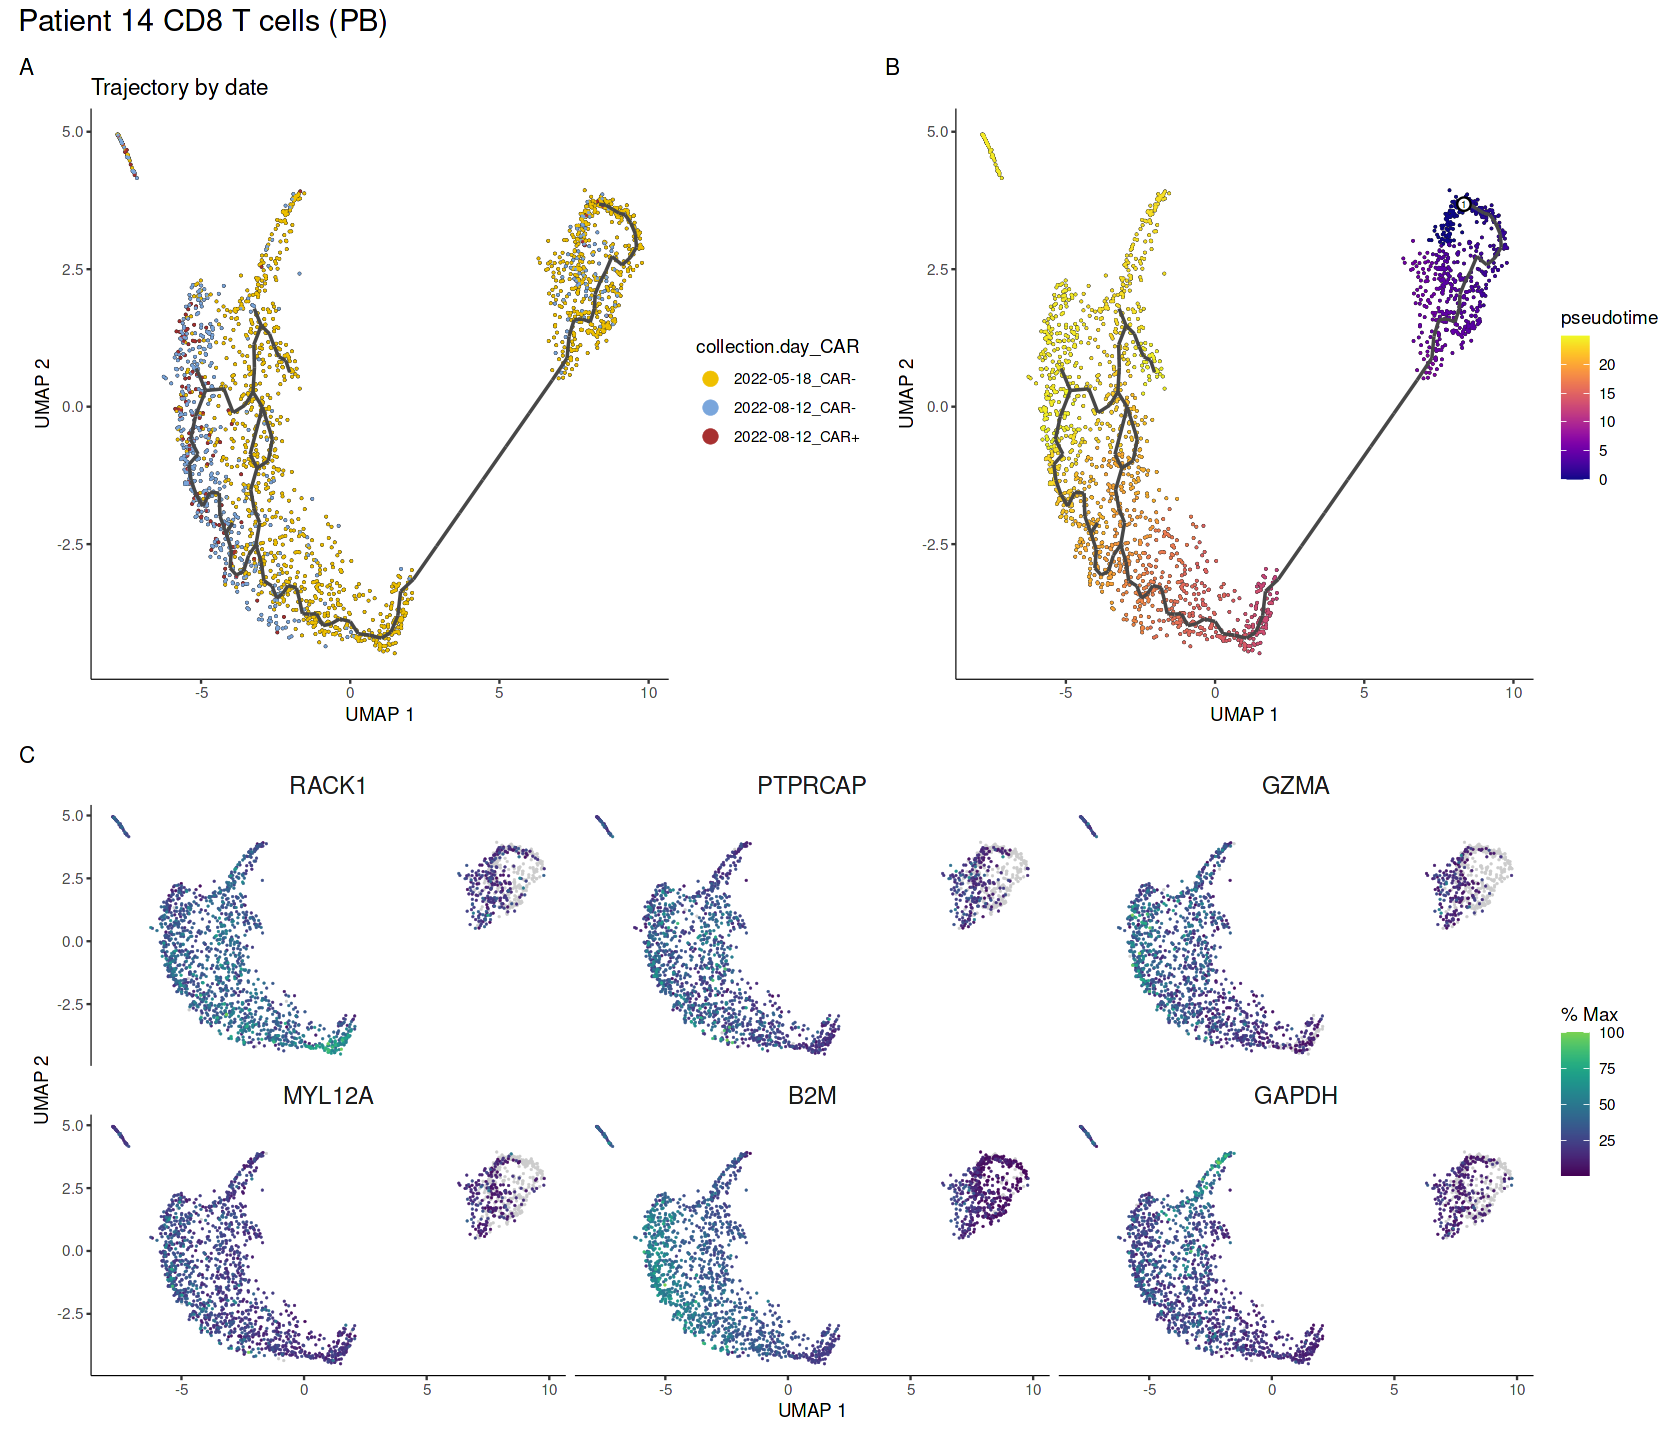

In [247]:
#Anchor point manually selected as per Max's request
options(repr.plot.width = 14, repr.plot.height = 12)
plot_all(p14_CD8)

Fig 8